# Analysis of the data regarding the books of the Capitolare libarary
This notebook analyze a data-set conatining the informations regarding the books of the Capitolare library of Verona. It shows how these data can be used for designing a multimodal system for acquiring and digitalizing the books.


## Source of the data
The data-set has been extracted manually from the catlogue of the library __Spagnolo, A., & Marchi, S. (1996). I manoscritti della Biblioteca Capitolare di Verona: catalogo descrittivo. Casa Editrice Mazziana__.
This catalouge was written by don Antonio Spagnolo and corrected in the newer editions. The corrections are written in the catalouge within braces {} we kept the corrected values and ingored the old wrong one.
The index assigned to the codexes is in roman letter but notice 'CM' and 'CD' are not used and 'IIII' is found in some case instead of 'IV', we kept this notation. Some values seems wrong we however kept the original dataset notify the incongruecies in during the analysis. 

## What is missing in the source data
One thing that  unfortunatly is not written in the catalogue is the thikness of the book. This is infact a very important field for the design of the system. 



## Description of the dataset
These are the descriptions of the columns: 

  -  **index_f**: integer index 
  -  **numero_del_codice**: item identifier of the library, it contains the index in capital letters witout parentesis and with the superscripts as capital letters.
  -  **fogli**: number of sheets copied from the text when indicated as ff. or calculated with a positive rounding of this formula number of pages /2 + number of sheets. White sheets are counted.
  -  **altezza**: height of the item
  -  **ampiezza**: widht of the item 
  -  **materiale**: material can be "membranaceo" parchment, "cartaceo" paper or "bombacino" linen paper.
  -  **rilegatura**: can be "rilegato" bounded, "fascicoli" paper files, "fogli sciolti" unbounded sheet.
  -  **palinsesto**: value 1 if the record is a palinsest 
  -  **testo_indistinto**: value 1 if the text is not clearly legible 
  -  **danni_fuoco**: value 1 if the author record fire damage (this attribution may be uncertian)
  -  **cancro_pergamena**: value 1 if damange may be attribute to parchment biological deterioration
  -  **margini_danneggiati**: value 1 if manuscripts have damaged margins
  -  **danni_umidita**: value 1 if the manuscripts has damaged caused by humidity
  -  **restaurato**: value 1 if it has been restored
  -  **dorature**: not used
  -  **colori**: note used
  -  **titolo**: we wrote the title only of a limited ammount of books
  -  **note**: some notes are written in this field.
  
We add a new integer index because we kept separated volumes with the same **numero di codice**. 


In [2]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np 
import pandas as pd
import seaborn as sns
import os 
from bokeh.io import output_file, show,output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper#, CategoricalMarkerMapper
from bokeh.palettes import plasma
from bokeh.plotting import figure
paperISOdimension = [
    (420,594,"A2"),
    (297,420,"A3"),
    (210,297,"A4"),
    (148,210,"A5"),
    (105,148,"A6"),
    (74,105,"A7"),
    (52,74,"A8")]

paperISOdimension2 = [
    (1189, 841, "A0"),
    (841,594, "A1"),
    (594,420,"A2"),
    (420,297,"A3"),
    (297,210,"A4"),
    (210,148,"A5"),
    (148,105,"A6"),
    (105,74,"A7"),
    (74 ,52,"A8")]

In [3]:
from bokeh.transform import transform

ImportError: No module named transform

In this analysis we will use the **numpy** and **pandas** for the numerial analysis. For vizualizing the data we will firt use **bokeh** this allow us an interactive view for spotting outliers and getting an overwiew of the data, then we will use seaborn and **matplotlib** for visualizing the data on the notebook and matplotlib2tikz for pubblication plot.
We start analzing the completeness of the dataset.

altezza has 76.0% of the values.
ampiezza has 76.0% of the values.
fogli has 75.0% of the values.
materiale has 99.0% of the values.
rilegatura has 94.0% of the values.


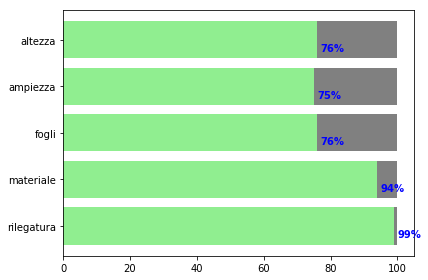

In [20]:
# Load the dataset
data = pd.read_csv(os.path.join('Data','lista manoscritti - version_2.1.csv'))
# Calculate completeness
campi = ['altezza','ampiezza','fogli','materiale','rilegatura']
diz = {}
for i in campi:
    diz[i] = round(eval("data.%s.count()/float(data.index_f.count())*100" %(i)))
    print("%s has %s%% of the values." %(i,diz[i]))    
fig = plt.figure()
ax = fig.add_subplot(111)
y_pos = np.arange(len(campi))
percents =  list(diz.values())
ax.barh(y_pos,[100]*len(campi), align='center', color='gray', ecolor='black')
ax.barh(y_pos,percents, align='center', color='lightgreen', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(campi)
for i, v in enumerate(percents):
    ax.text(v + 1, i + .25, ("%s%%")%(int(v)), color='blue', fontweight='bold')
ax.invert_yaxis()  # labels
plt.tight_layout()
fig.savefig('Completezzadati.pdf')

### Interpetation
We have aproximately the 76% of the values of widht and height of the books. Some materials is collected in envelopes and they have different width and height this means that variations could be greater. The information regarding the sheets are uncertain: of 75% of the catalogue entries had the number of sheets. The esteem regarding the material and the bounding can be much more precise.

In [22]:
data.altezza

0       270
1       270
2       282
3       250
4       335
5       285
6       320
7       NaN
8       200
9       285
10      215
11      300
12      235
13      186
14      150
15      234
16      272
17      313
18      233
19      348
20      348
21      348
22      253
23      325
24      320
25      220
26      217
27      197
28      210
29      282
       ... 
1288    NaN
1289    NaN
1290    NaN
1291    NaN
1292    NaN
1293    NaN
1294    NaN
1295    NaN
1296    NaN
1297    NaN
1298    NaN
1299    NaN
1300    NaN
1301    NaN
1302    NaN
1303    NaN
1304    NaN
1305    NaN
1306    NaN
1307    NaN
1308    NaN
1309    NaN
1310    NaN
1311    NaN
1312    NaN
1313    NaN
1314    NaN
1315    NaN
1316    NaN
1317    NaN
Name: altezza, dtype: float64

In [25]:
#We add new columns
data['Area_cm2'] = (data.altezza/100)*(data.ampiezza/100)
data['Damaged'] = data.danni_fuoco.fillna(0) + data.cancro_pergamena.fillna(0) + data.danni_umidita.fillna(0) + data.margini_danneggiati.fillna(0)
data['Aspect_ratio'] = data.altezza/data.ampiezza
#One important column is the width when the book is open
maskril = data.rilegatura == 'rilegato'
data['raccolte di fogli'] = data.ampiezza
# the bounded books can be opened
data['Width_open_book'] = data['ampiezza']
data['Width_open_book'][~maskril] = data['ampiezza'][~maskril]*2
#We described the dataset
data.describe()
print(maskril)
print(data.Aspect_ratio.iloc[785])
print(data.index_f.iloc[785])
print(data.altezza.iloc[785], data.ampiezza.iloc[785])

0        True
1       False
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18      False
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
1288    False
1289    False
1290     True
1291    False
1292    False
1293    False
1294     True
1295     True
1296     True
1297     True
1298     True
1299     True
1300     True
1301     True
1302     True
1303     True
1304     True
1305     True
1306     True
1307    False
1308     True
1309     True
1310     True
1311    False
1312    False
1313    False
1314    False
1315     True
1316    False
1317     True
Name: rilegatura, dtype: bool
1.47058823529
777.0
(375.0, 255.0)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [26]:
data.materiale.value_counts()

cartaceo                  991
membranaceo               292
bombacino                  12
membranaceo e cartaceo      3
Name: materiale, dtype: int64

In [27]:
data.rilegatura.value_counts()

rilegato             1020
fascicoli             120
fogli sciolti          85
raccolte di fogli      12
Name: rilegatura, dtype: int64

In [28]:
datamat =data.groupby('materiale')
datamat.fogli.sum()

materiale
bombacino                  2210
cartaceo                  97208
membranaceo               40312
membranaceo e cartaceo      171
Name: fogli, dtype: float64

In [29]:
numero_fogli = data.fogli.sum()
print(numero_fogli)

139901.0


In [30]:
numero_fogli*2

279802.0

In [31]:
rilegati = 1087
facciate_di_rilegatura = rilegati*5
print(facciate_di_rilegatura)
facciate_di_rilegatura_contagli = rilegati*8
print(facciate_di_rilegatura_contagli)

5435
8696


In [32]:
stima_totale_acquisizioni = numero_fogli*2 + facciate_di_rilegatura
print(stima_totale_acquisizioni)
totalicontagli = numero_fogli*2 + facciate_di_rilegatura_contagli
print(totalicontagli)

print("Acquisizioni totali con tagli: %s " %totalicontagli)
print("GB totali (100 MB per immagine): %s GB "%(totalicontagli*0.1))
print("Costo mensile amazon webserver (0.0125 $/GB): %s $" %(totalicontagli*0.1*0.0125))
print("Costo annuo amazon webserver (0.0125 $/GB): %s $" %(totalicontagli*0.1*0.0125*12))

285237.0
288498.0
Acquisizioni totali con tagli: 288498.0 
GB totali (100 MB per immagine): 28849.8 GB 
Costo mensile amazon webserver (0.0125 $/GB): 360.6225 $
Costo annuo amazon webserver (0.0125 $/GB): 4327.47 $


In [33]:
facciate_perg  = 282*8
numero_fogliP = 39819
stima_totale_acquisizioni_perg = numero_fogliP*2 + 282
print("Acquisizioni totali: %s " %stima_totale_acquisizioni_perg)
print("GB totali (100 MB per immagine): %s GB "%(stima_totale_acquisizioni_perg*0.1))
print("Costo mensile amazon webserver (0.0125 $/GB): %s $" %(stima_totale_acquisizioni_perg*0.1*0.0125))
print("Costo annuo amazon webserver (0.0125 $/GB): %s $" %(stima_totale_acquisizioni_perg*0.1*0.0125*12))

Acquisizioni totali: 79920 
GB totali (100 MB per immagine): 7992.0 GB 
Costo mensile amazon webserver (0.0125 $/GB): 99.9 $
Costo annuo amazon webserver (0.0125 $/GB): 1198.8 $


In [34]:
data.describe()

,index_f,datazione_i,datazione_f,fogli,altezza,ampiezza,palinsesto,testo_indistinto,danni_fuoco,cancro_pergamena,...,disegni,miniato,colori,rosso,blue,Area_cm2,Damaged,Aspect_ratio,raccolte di fogli,Width_open_book
count,1309.000000,1120.000000,1120.000000,985.000000,999.000000,999.000000,15,18,6,4,...,140,142,160,250,72,999.000000,1318.000000,999.000000,999.000000,999.000000
mean,654.726509,15.164286,16.229018,142.031472,263.327327,185.308308,1,1,1,1,...,1,1,1,1,1,5.290163,0.032625,1.440964,185.308308,194.978979
std,377.970724,2.913965,2.767039,102.945700,119.493939,57.353761,0,0,0,0,...,0,0,0,0,0,3.994065,0.186070,0.541710,57.353761,73.664438
min,1.000000,3.000000,4.000000,1.000000,67.000000,28.000000,1,1,1,1,...,1,1,1,1,1,0.335000,0.000000,0.568000,28.000000,28.000000
25%,328.000000,14.000000,15.000000,63.000000,215.000000,152.000000,1,1,1,1,...,1,1,1,1,1,3.264450,0.000000,1.356015,152.000000,152.000000
50%,654.000000,16.750000,18.000000,121.000000,240.000000,172.000000,1,1,1,1,...,1,1,1,1,1,4.165000,0.000000,1.421053,172.000000,177.000000
75%,982.000000,17.000000,18.000000,212.000000,300.000000,210.000000,1,1,1,1,...,1,1,1,1,1,6.256000,0.000000,1.458065,210.000000,218.500000
max,1309.000000,18.500000,19.000000,768.000000,3112.000000,535.000000,1,1,1,1,...,1,1,1,1,1,66.908000,2.000000,14.474419,535.000000,796.000000


### Interpetation
The catalouge is composed mainly of paper books (992) and parchments (282). Most of them are bounded. We have four palinsests and 40 books with illegible text, 30 of them are damaged and 7 have been restored. 

In [35]:
TOOLS = "hover,pan,wheel_zoom,box_zoom,reset,save"
source = ColumnDataSource(data=dict(x=data.ampiezza, y=data.altezza, 
                                    cod=data.numero_del_codice,
                                    fogli = data.fogli,
                                    index_f = data.index_f,
                                    titolo = data.titolo,
                                    materiale = data.materiale))

mapper = LinearColorMapper(palette=plasma(256), low=0, high=1307)
#markmapper =CategoricalMarkerMapper(['hex', 'circle_x', 'triangle'])
p = figure(plot_width=900, plot_height=700, tools=TOOLS, title="Width and height of the books",match_aspect=True)
p.circle('x', 'y', size=6, alpha = 0.4, source=source,
         fill_color=transform('index_f', mapper)),
         #marker=transform('materiale',markmapper))
p.xaxis.axis_label = "Width  (mm)"
p.yaxis.axis_label = "Height (mm)"
p.hover.tooltips = [
    ("index", "$index"),
    ("(h,w)", "@y x @x mm"),
    ('Numero del codice', '@cod'),
    ('Fogli','@fogli'),
    ('Titolo','@titolo'),
    ('Materiale','@materiale')
]
output_notebook()
output_file('analisi dimensionale.html')
show(p)

AttributeError: unexpected attribute 'match_aspect' to Figure, possible attributes are above, background_fill_alpha, background_fill_color, below, border_fill_alpha, border_fill_color, css_classes, disabled, extra_x_ranges, extra_y_ranges, h_symmetry, height, hidpi, inner_height, inner_width, js_callbacks, left, lod_factor, lod_interval, lod_threshold, lod_timeout, min_border, min_border_bottom, min_border_left, min_border_right, min_border_top, name, outline_line_alpha, outline_line_cap, outline_line_color, outline_line_dash, outline_line_dash_offset, outline_line_join, outline_line_width, plot_height, plot_width, renderers, right, sizing_mode, tags, title, title_location, tool_events, toolbar, toolbar_location, toolbar_sticky, v_symmetry, webgl, width, x_mapper_type, x_range, y_mapper_type or y_range

We can see some strange items like the item with index 785 (3 meters height) and the with index 788 only 3 cm width.
These are clearly outliers, we'll mask them from the following conputaions.

In [36]:
data.altezza = data.altezza.mask(data.altezza > 1000 )
data.ampiezza = data.ampiezza.mask(data.ampiezza < 40)
# We mask also the measurment thtat derive from this calculation
data.Area_cm2 = data.Area_cm2.mask( data.ampiezza < 40)
data.Area_cm2 = data.Area_cm2.mask(data.altezza > 1000) 
data.Aspect_ratio = data.Aspect_ratio.mask(data.ampiezza < 40)
data.Aspect_ratio = data.Aspect_ratio.mask(data.altezza > 1000)

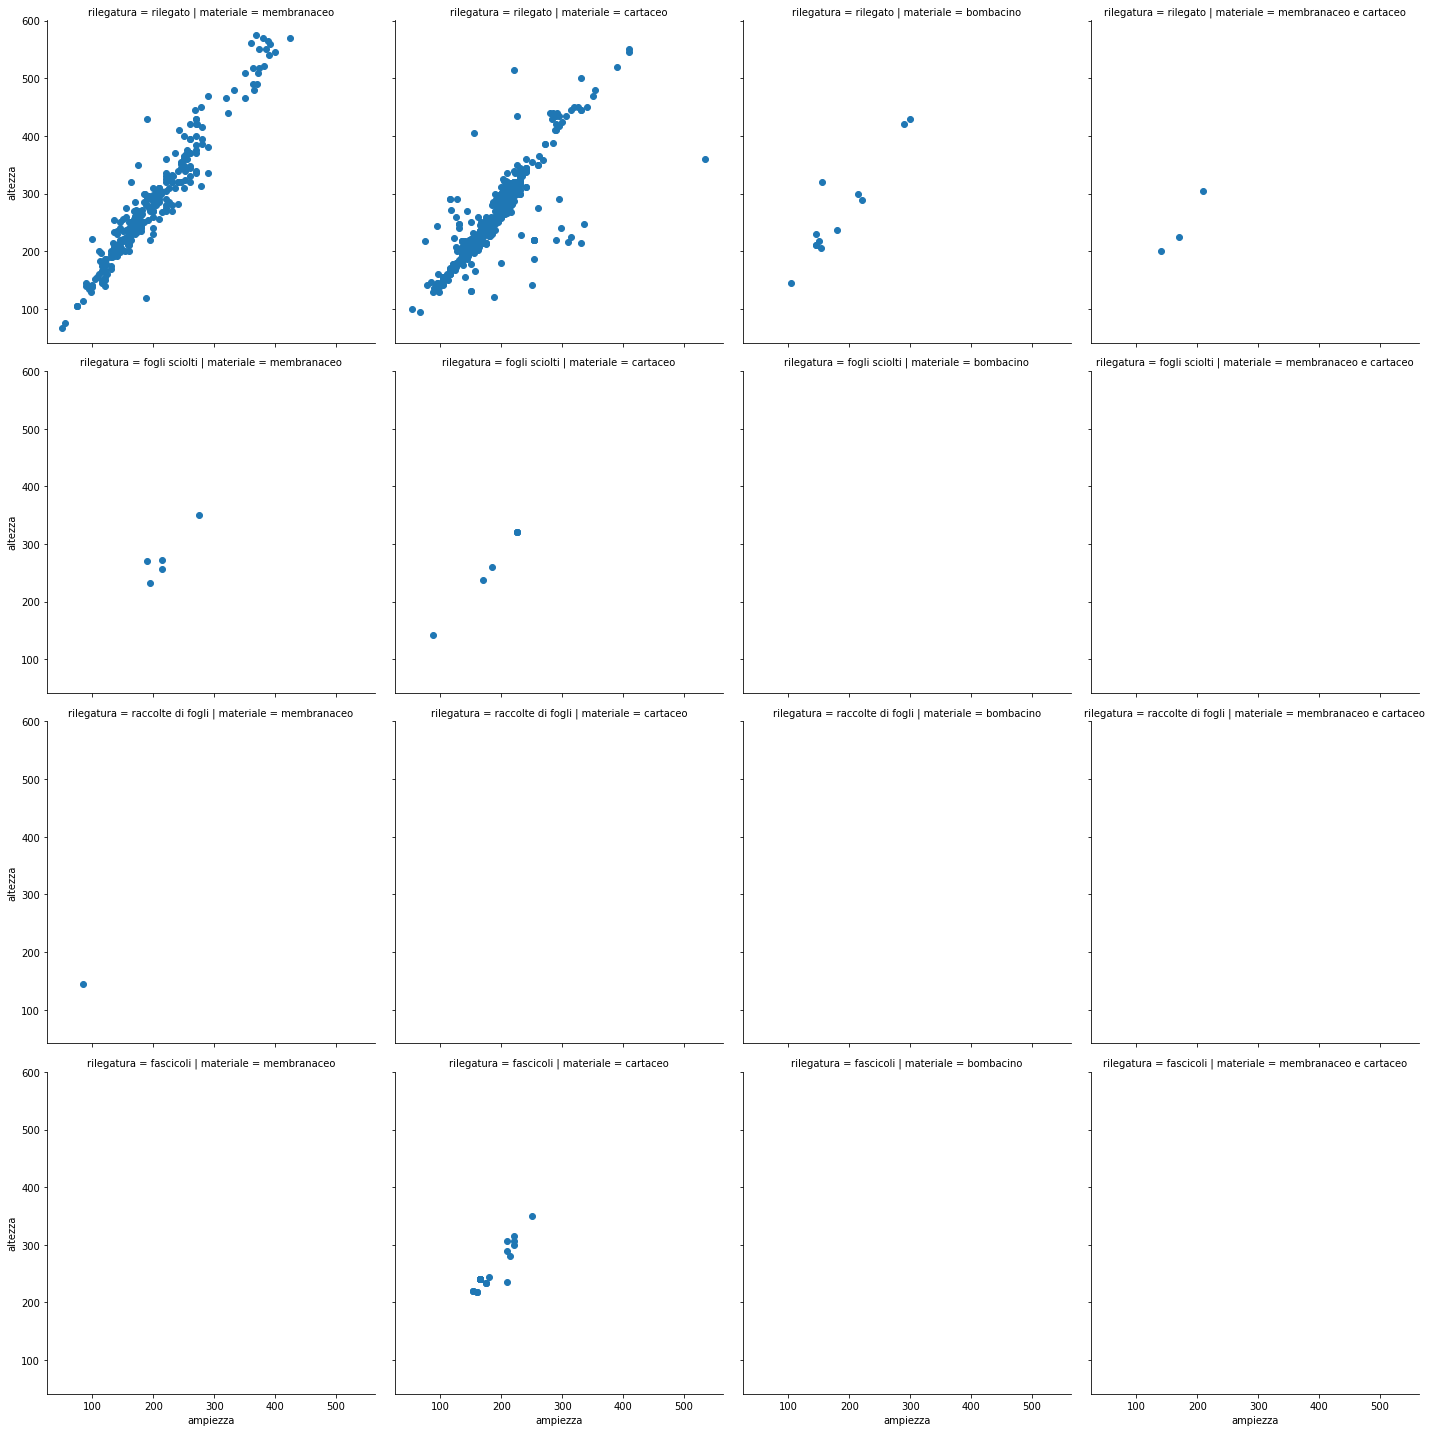

In [37]:
plt.rcParams['figure.figsize'] = (30,10)
grid = sns.FacetGrid(data, col="materiale",row ="rilegatura", palette="tab20c", height=5)
grid.map(plt.scatter, "ampiezza", "altezza", marker="o")
grid.fig.tight_layout(w_pad=1)

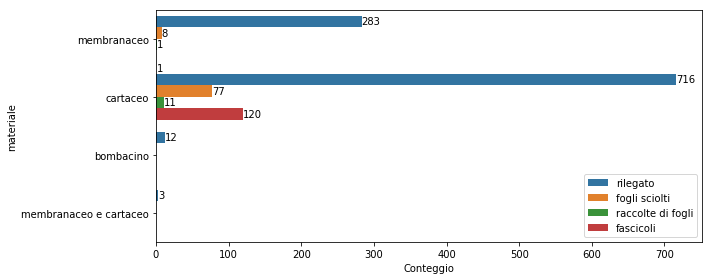

In [38]:
fig, axc = plt.subplots(figsize=(10,4))
sns.countplot(y="materiale", hue="rilegatura", data=data,ax=axc)
#axc.semilogx()
axc.legend(loc='lower right')
#t = axc.set_xticklabels([0,0,1,10,100])
axc.set_xlabel('Conteggio')
for i in axc.get_children():
    if str(type(i)) == "<class 'matplotlib.patches.Rectangle'>":
        bb = i.get_bbox()
        if np.isnan(bb).any():
            continue
        else:
            axc.text(bb.x1,(bb.y1-bb.y0)/2+bb.y0,  str(int(bb.x1)),verticalalignment='center')
            
plt.tight_layout()
fig.savefig('Contmaterile.pdf')

The catalogue shows that most of the parchments are bounded,  the majory of the un-bounded books are made of paper. All the example of bombacino are bounded. We can try to get more accurate esteem of time needed using the number of sheeets.

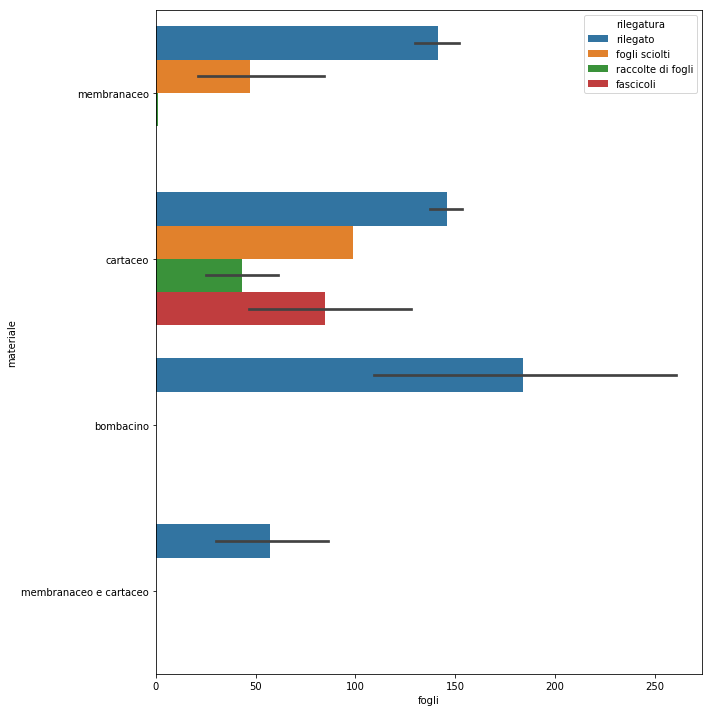

In [39]:
plt.rcParams['figure.figsize'] = (10,10)
ax = sns.barplot(x="fogli", y="materiale",hue="rilegatura", data=data)
plt.tight_layout()
plt.savefig('Numero_pagine.pdf')

We have an average of 150 sheets (300 pages) of parchements or paper in the bounded books. The spare sheets vary a lot depending on the collection. While the files are usually of 50 sheets (100 pages) each. An overall view can be achieved with the scatter plot:

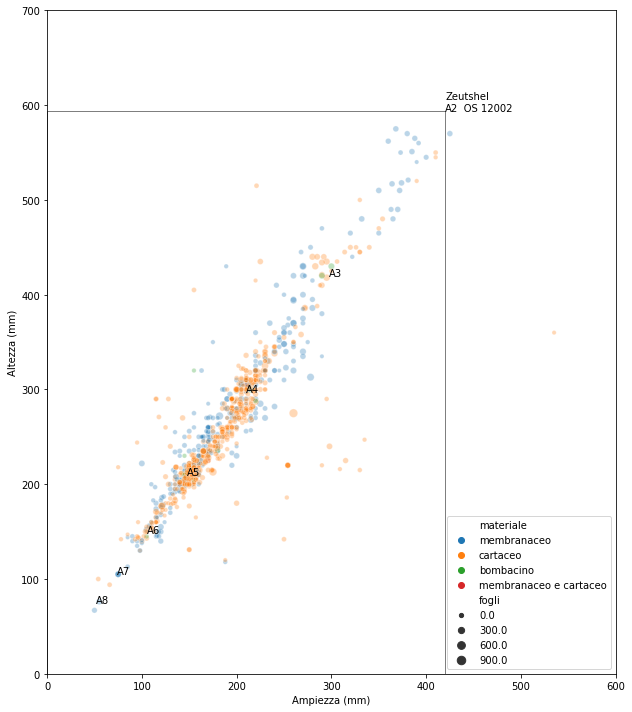

In [40]:
plt.rcParams['figure.figsize'] = (10,10)
ax =sns.scatterplot(x="ampiezza", y="altezza", hue = "materiale", size = "fogli", data=data, alpha = 0.3,)
ax.set_aspect('equal')
ax.legend(loc="lower right")
ax.set_ylabel("Altezza (mm)")
ax.set_xlabel("Ampiezza (mm)")
#ax.vlines([70,300],0,700,alpha=0.5)
#ax.hlines([100,400],0,700,alpha=0.5)
for i in paperISOdimension:
    ax.text(*i)

camera_max_FOV = [
    (420,594,"Zeutshel\n      OS 12002"),
]
for j in camera_max_FOV:
    ax.add_patch(
         patches.Rectangle(
            (0, 0),
            j[0],
            j[1],
            fill=False,      # remove background
         alpha=0.5) )
    ax.text(*j)
plt.xlim(0,600)
plt.ylim(0,700)
plt.tight_layout()
plt.savefig("Closed_item_dim.pdf")

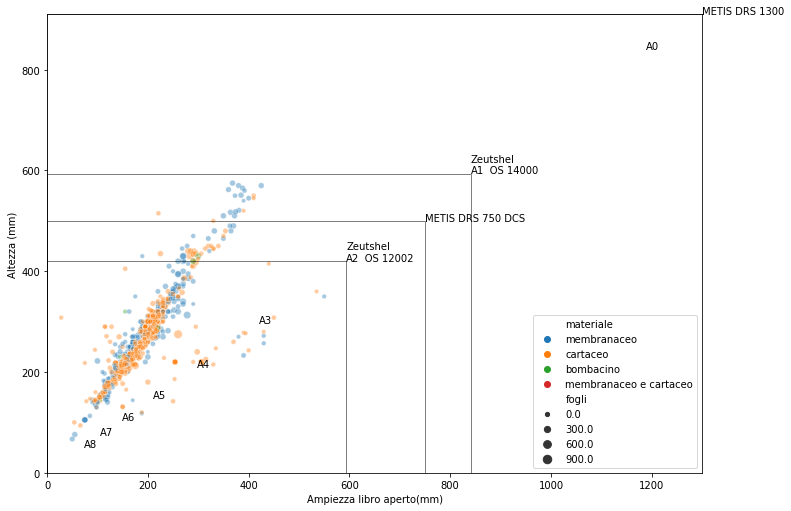

In [41]:
plt.rcParams['figure.figsize'] = (10,10)
ax =sns.scatterplot(x="Width_open_book", y="altezza", hue = "materiale", size = "fogli", data=data, alpha = 0.4)
ax.set_aspect('equal')
ax.set_ylabel("Altezza (mm)")
ax.set_xlabel("Ampiezza libro aperto(mm)")
ax.set_ylim(0,910)
ax.set_xlim(0,1300)
for i in paperISOdimension2:
    ax.text(*i)

camera_max_FOV = [
    (1300,910,"METIS DRS 1300"),
    (750,500,"METIS DRS 750 DCS"),
    (841,594, "Zeutshel\n      OS 14000"),
    (594,420, "Zeutshel\n      OS 12002"),
]

artists = []
for j in camera_max_FOV:
    art =  patches.Rectangle(
            (0, 0),
            j[0],
            j[1],
            fill=False,      # remove background
         alpha=0.5)
    ax.add_patch(art)
    txt = ax.text(*j)
    artists.append(txt)
    
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("open_item_dimension.pdf", bbox_extra_artists=artists,bbox_inches='tight')

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

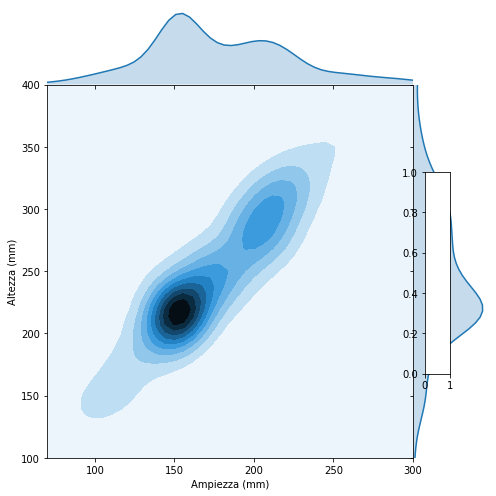

In [42]:
# We get a more precise ditribution of the area.
g = sns.jointplot(data.ampiezza, data.altezza, kind="kde", height=7, space=0,xlim=(70,300),ylim=(100,400))
g.set_axis_labels(xlabel = 'Ampiezza (mm)',ylabel = "Altezza (mm)")
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)

plt.savefig("Distributionlenght.pdf")

We can see that the overal distribution of sizes is bi-modala mostly A5 and A4.

1.42105263158


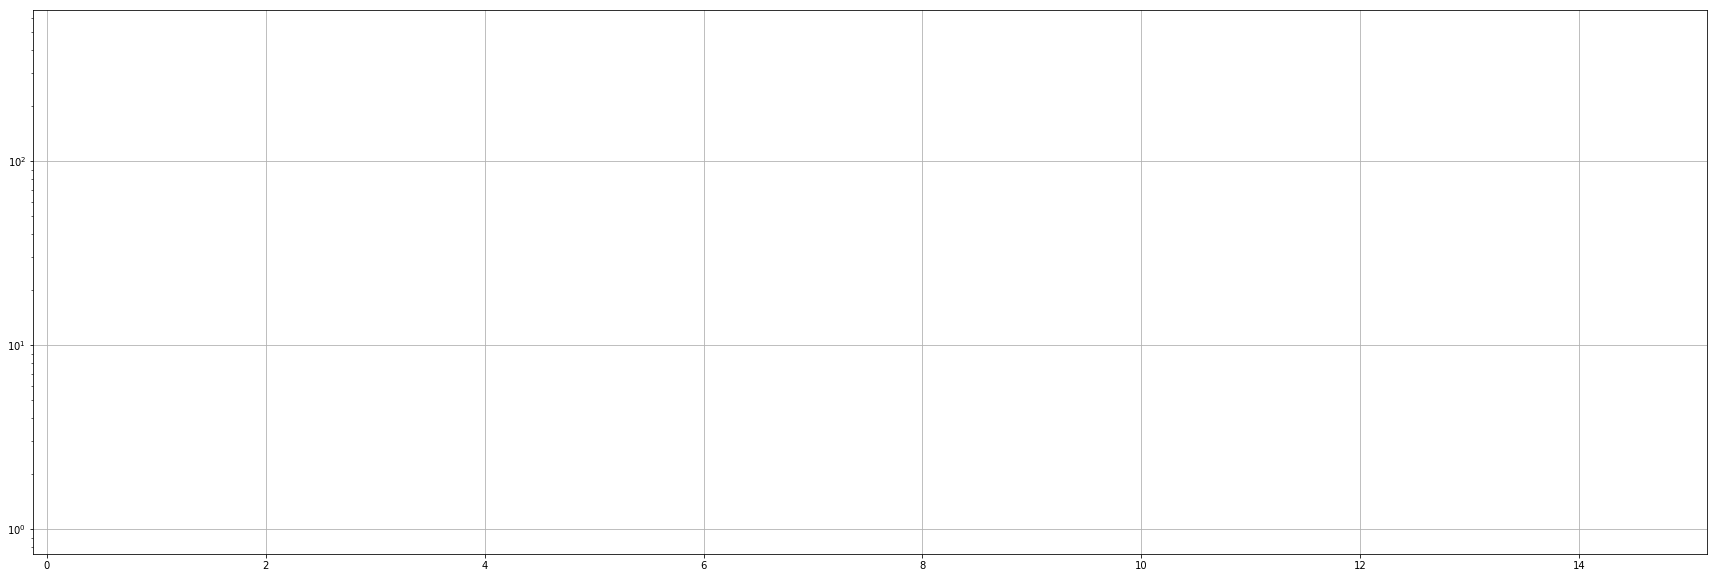

In [43]:
plt.rcParams['figure.figsize'] = (30,10)
ax3 = data.Aspect_ratio.hist(bins=100)
ax3.semilogy()
print(data.Aspect_ratio.median())

[]

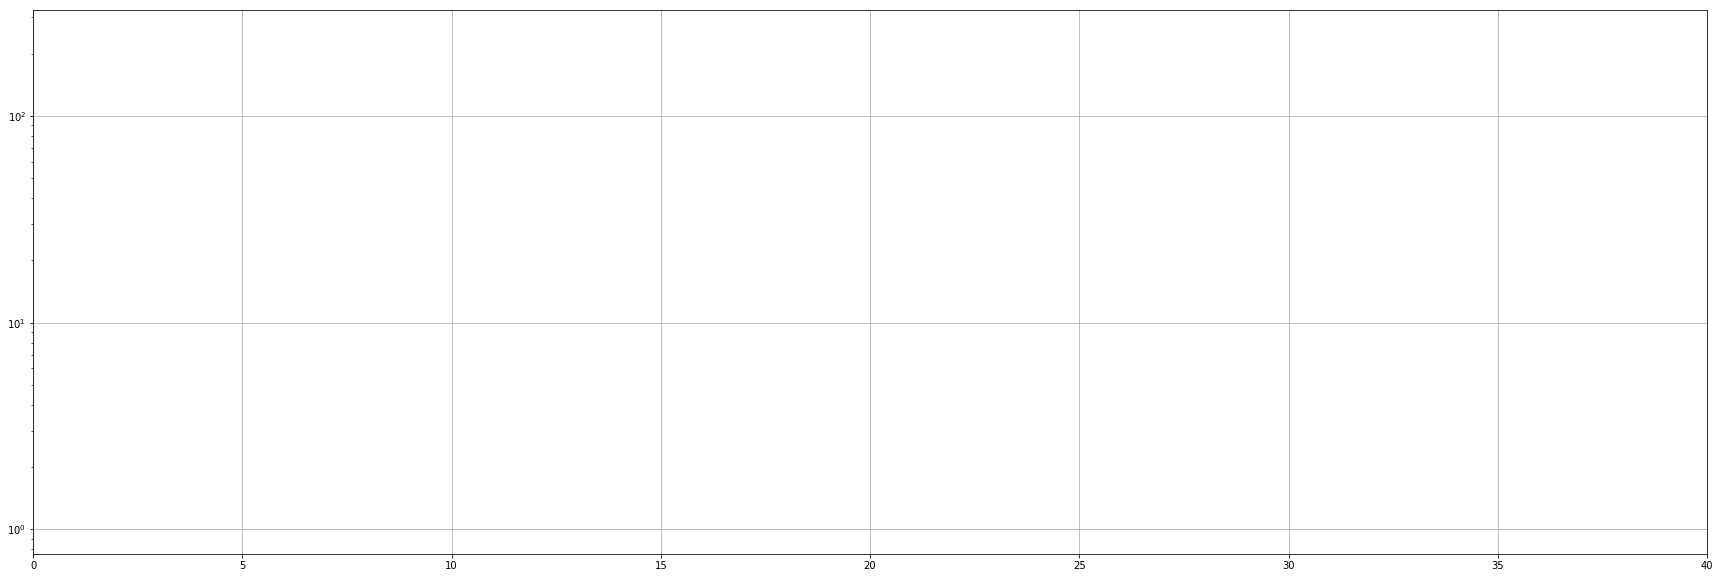

In [44]:
ax2 = data.Area_cm2.hist(bins=100)
ax2.set_xlim(0,40)
ax2.semilogy()

In [55]:
data.datazione_i

dtype('float64')

In [56]:
data2 = data.sort_values(by=['datazione_i'])

In [64]:
pd.set_option('display.max_rows', None)
data2.datazione_f

44       4.00
45       4.00
0        6.00
1       10.00
31       7.00
5        6.00
46       6.00
9        6.00
16       6.00
17       6.00
42       7.00
47       6.00
58       7.00
66       7.00
20       7.00
41       5.25
40       8.00
70       6.25
2        7.00
4        6.00
25       5.75
67       7.00
13       8.00
62       6.25
60       7.00
94       6.50
98       9.00
6        8.00
3        8.00
18       7.50
68       7.50
43       9.00
69       9.00
102      9.00
53       8.00
49       9.00
101      9.00
14      15.25
36       9.00
10       8.00
11      10.00
64      11.00
65      10.00
19       9.00
73      10.00
115     10.00
76       9.00
77       8.50
82      11.00
22      10.00
83       9.00
84      10.00
104     10.00
91      10.00
95       9.00
97      10.00
110     11.00
59      10.00
51      10.00
33       9.00
54      11.00
34       9.00
50       9.00
100     10.00
26      10.00
52      10.00
99      10.00
63       9.25
39       9.00
32       9.00
30      11.00
90    

In [155]:
fig = plt.figure(figsize=(20,95))
ax = fig.add_subplot(111)
c = 0
spacing = 8
def colors(mat):
    if isinstance(mat,str):
        colors = {'membranaceo':'blue',
                  'membranaceo e cartaceo':'green',
                 'cartaceo':'orange',
                 'bombacino':'cyan',
                }
        return colors[mat]
    else:
        return 'black'
fmax = data2.fogli.max()
def widthl(fogli):
    if np.isnan(fogli):
        return 1
    else:
        return 1 + (spacing-1)*fogli/fmax

def settitle(title):
    if isinstance(title,str):
        return title.decode('utf-8')
    else:
        return "n.a."

        
    
for index, row in data2.iterrows():
    if not np.isnan(row['datazione_i']) and not np.isnan(row['datazione_f']):
        ax.hlines(xmin=row['datazione_i']*100,xmax=row['datazione_f']*100,y=c,
                  color = colors(row['materiale']),
                  alpha=0.5,
                  linewidth=widthl(row['fogli']))
        ax.text(x=row['datazione_f']*100,y=c,
                s=settitle(row['titolo']),
                fontsize=7,
                va='center')
        c-=spacing
    else:
        print('nan')
    
ax.set_xlabel('Year')
ax.set_ylim(-1150*spacing,10)
ax.set_xlim(200,2050)

ax.axes.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks(np.arange(200, 1900,100))
a2 = ax.twiny()
a2.xaxis.set_ticks(np.arange(200, 1900,100))
a2.set_xlim(200,2050)
a2.set_xlabel('Year')
ax.grid()
plt.tight_layout()
fig.savefig('distribuzione_date_d_width_name.pdf')

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [142]:
%debug

> /usr/local/lib/python2.7/dist-packages/matplotlib/text.py(802)draw()
    800                     textrenderer.draw_text(gc, x, y, clean_line,
    801                                            textobj._fontproperties, angle,
--> 802                                            ismath=ismath, mtext=mtext)
    803 
    804         gc.restore()

ipdb> q


In [81]:
import math

In [82]:
math.isnan('test')

TypeError: a float is required

In [95]:
row['fogli']

nan